# Cleaning University of California Berkeley Power Consumption Dataset

The data retrieved from [UCB's energy dashboard](https://engagementdashboard.com/ucb/ucb) regarding power consumption in UCB's Mechanical Engineering building is in the form of a `json` format. Here we'll be converting it into a `csv` file for later data analysis. 

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pprint
import requests
from datetime import datetime

In [28]:
#Format into dates
def format_time(unix_timestamp):
    format = '%Y-%m-%d'
    ts = int(unix_timestamp)
    return datetime.utcfromtimestamp(ts).strftime(format)

#Create list of datetime objects from timestamps
def gen_datetimes(li):
    datetimes = []
    for time in li:
        datetimes.append(datetime.utcfromtimestamp(time))
    return datetimes

#Get day of week based on date
def get_weekday(dates):
    return [1 if (datetime.strptime(d,"%Y-%m-%d").weekday() >= 5) else 0 for d in dates]

In [33]:
#Making requests
def make_request(location_id):
    #NOTE: Make sure the start and end time are exactly the same as current date.
    url = "https://engagementdashboard.com/a/consumption?endTime=2020-11-19T19:59:59.000Z&granularity=DAY&locationIds=" + str(location_id) + "&resource=Electricity&startTime=2019-11-19T20:00:00.000Z"
    payload = {}
    headers = {}
    response = requests.request("GET", url, headers=headers, data = payload)
    return response.json()

In [26]:
#Parse JSON string into dataframe for power
def parse_json(json_string):
    data = json_string[0]
    
    #Split dataset
    actual = data['actual']
    
    #Create new dataframe
    df_power = pd.DataFrame(columns = ['act_power', 'date', 'timestamp'])
    df_power.head()
    
    actual_li = actual['data']
    loc = 0

    for i in range(len(actual_li)):
        #Get corresponding dicts
        dt1 = actual_li[i]

        #Get data in appropriate format
        time = format_time(dt1['timestamp'])
        act_power = dt1['value']
        ts = dt1['timestamp']

        #Add to dataframe
        df_power.loc[loc] = [act_power, time, ts]

        #Increment location tracker
        loc += 1

    #Add Weekdays 
    df_power['Weekday'] = get_weekday(df_power['date'])
    
    return df_power

In [32]:
#Merge weather data and power data 
def merge_weather(df_power, weather_data='Datasets/Berkeley_Weather.csv'):
    #Read data, drop unused columns and remove 0 values
    df_weather = pd.read_csv('Datasets/Berkeley_Weather.csv', skiprows=2)
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    
    #Split into Y M and D
    df_power[['Year', 'Month', 'Day']] = df_power.date.str.split('-', expand=True).apply(pd.to_numeric)

    #Merge data together
    df_merge = df_weather.merge(df_power[['act_power', 'Month', 'Day', 'Weekday']], left_on=('Month', 'Day'), right_on=('Month', 'Day'), how = 'inner', suffixes=('_left','_right'))
    df_merge = df_merge.rename(columns={'act_power': 'Power Consumption', 'DNI':'DNI Mean'})
    df_merge = df_merge.drop(columns=['Dew Point'])
    
    return df_merge

In [55]:
#Simplified lambda expression for doing all three steps at once.
gen_data = lambda building_id : merge_weather(parse_json(make_request(building_id)))

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Power Consumption,Weekday
0,2019,1,1,722.400000,952,45,2.120000,0.555000,47.750000,43.414000,8.555000,1004.550000,7888.0,0
1,2019,1,2,714.100000,925,67,1.465000,1.000000,66.050000,57.277500,9.150000,1004.400000,8323.0,0
2,2019,1,3,480.100000,899,14,2.040000,0.975000,75.850000,64.874500,8.680000,1001.750000,8468.0,0
3,2019,1,4,579.950000,912,30,1.675000,0.985000,111.300000,73.464000,9.970000,994.650000,8177.0,1
4,2019,1,5,25.388889,93,1,6.194444,1.955556,182.500000,90.365556,11.500000,985.000000,8188.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019,12,27,601.050000,888,25,2.270000,0.755000,305.250000,67.604500,9.935000,998.650000,8008.0,0
361,2019,12,28,661.400000,903,14,1.185000,1.285000,170.350000,68.861000,10.400000,1001.100000,7950.0,1
362,2019,12,29,38.428571,100,1,1.964286,1.971429,202.357143,94.118571,10.707143,999.214286,7911.0,1
363,2019,12,30,666.350000,883,59,2.105000,1.300000,252.450000,82.484000,10.880000,1000.200000,7997.0,0


In [45]:
#List of datapoints we're interested in.
data = {
    257 : {
        "University Name": "University of California, Berkeley",
        "Building Name": "Etcheverry Hall",
        "Square Feet": 179722
    },
    216 : {
        "University Name": "University of California, Berkeley",
        "Building Name": "Energy Biosciences Building",
        "Square Feet": 124175
    },
    278 : {
        "University Name": "University of California, Berkeley",
        "Building Name": "Silver Space Sciences Laboratory",
        "Square Feet": 45124 
    },
    275 : {
        "University Name": "University of California, Berkeley",
        "Building Name": "Lawrence Hall of Science",
        "Square Feet": 131464
    },
}

In [46]:
#Add all rows to common DataFrame, with diffrentiating factors included

df = pd.DataFrame()

for key in data:
    current_df = gen_data(key)
    for inner_key in data[key]:
        current_df[inner_key] = data[key][inner_key]
    df = df.append(current_df)

df.head()

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet
0,2019,1,1,722.400000,952,45,2.120000,0.555000,47.75,43.414000,8.555,1004.55,7888.0,0,"University of California, Berkeley",Etcheverry Hall,179722
1,2019,1,2,714.100000,925,67,1.465000,1.000000,66.05,57.277500,9.150,1004.40,8323.0,0,"University of California, Berkeley",Etcheverry Hall,179722
2,2019,1,3,480.100000,899,14,2.040000,0.975000,75.85,64.874500,8.680,1001.75,8468.0,0,"University of California, Berkeley",Etcheverry Hall,179722
3,2019,1,4,579.950000,912,30,1.675000,0.985000,111.30,73.464000,9.970,994.65,8177.0,1,"University of California, Berkeley",Etcheverry Hall,179722
4,2019,1,5,25.388889,93,1,6.194444,1.955556,182.50,90.365556,11.500,985.00,8188.0,1,"University of California, Berkeley",Etcheverry Hall,179722


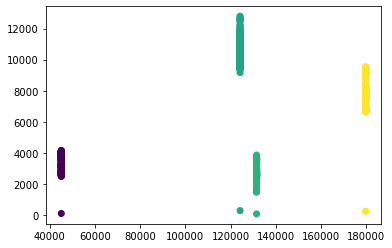

In [63]:
#Exploratory Analysis between Temperature and Power Consumption
import matplotlib.pyplot as plt

plt.scatter(df['Temperature'], df['Power Consumption'], c = df['Square Feet'])
plt.show()

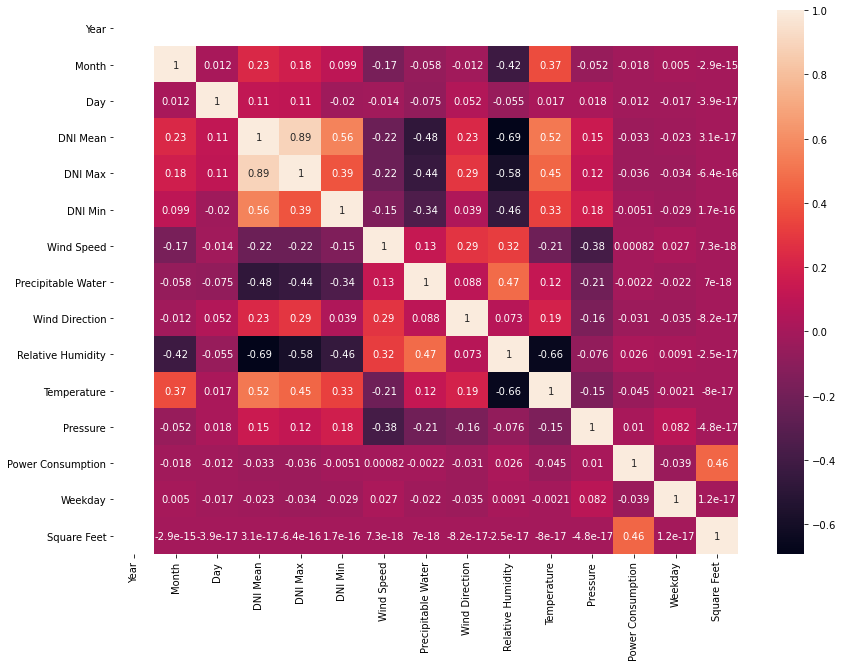

In [54]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True)
plt.show()